In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install optuna
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 21.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

import shap

#Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/NTDB-Epidural/final_data.csv', index_col = 0)

In [5]:
print(data['Hospital Complication - Cardiac Arrest with CPR'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Catheter-Related Blood Stream Infection'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Deep Surgical Site Infection'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Deep Vein Thrombosis (DVT)'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Pulmonary Embolism'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Unplanned Intubation'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Acute Kidney Injury'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Myocardial Infarction'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Unplanned Return to the OR'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Severe Sepsis'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Stroke  or  CVA'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Unplanned Admission to the ICU'].value_counts(normalize=False, dropna=False), '\n')
print(data['Hospital Complication - Ventilator-Associated Pneumonia (VAP)'].value_counts(normalize=False, dropna=False))

No         4751
Unknown      22
Yes          17
Name: Hospital Complication - Cardiac Arrest with CPR, dtype: int64 

No         4768
Unknown      22
Name: Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI), dtype: int64 

No    4790
Name: Hospital Complication - Catheter-Related Blood Stream Infection, dtype: int64 

No         4767
Unknown      22
Yes           1
Name: Hospital Complication - Deep Surgical Site Infection, dtype: int64 

No         4756
Unknown      22
Yes          12
Name: Hospital Complication - Deep Vein Thrombosis (DVT), dtype: int64 

No         4764
Unknown      22
Yes           4
Name: Hospital Complication - Pulmonary Embolism, dtype: int64 

No         4731
Yes          37
Unknown      22
Name: Hospital Complication - Unplanned Intubation, dtype: int64 

No         4757
Unknown      22
Yes          11
Name: Hospital Complication - Acute Kidney Injury, dtype: int64 

No         4767
Unknown      22
Yes           1
Name: Hospital Com

In [6]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Hospital Complication - Cardiac Arrest with CPR'] != 'Unknown']
data = data[data['Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)'] != 'Unknown']
data = data[data['Hospital Complication - Catheter-Related Blood Stream Infection'] != 'Unknown']
data = data[data['Hospital Complication - Deep Surgical Site Infection'] != 'Unknown']
data = data[data['Hospital Complication - Deep Vein Thrombosis (DVT)'] != 'Unknown']
data = data[data['Hospital Complication - Pulmonary Embolism'] != 'Unknown']
data = data[data['Hospital Complication - Unplanned Intubation'] != 'Unknown']
data = data[data['Hospital Complication - Acute Kidney Injury'] != 'Unknown']
data = data[data['Hospital Complication - Myocardial Infarction'] != 'Unknown']
data = data[data['Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)'] != 'Unknown']
data = data[data['Hospital Complication - Unplanned Return to the OR'] != 'Unknown']
data = data[data['Hospital Complication - Severe Sepsis'] != 'Unknown']
data = data[data['Hospital Complication - Stroke  or  CVA'] != 'Unknown']
data = data[data['Hospital Complication - Unplanned Admission to the ICU'] != 'Unknown']
data = data[data['Hospital Complication - Ventilator-Associated Pneumonia (VAP)'] != 'Unknown']
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  4790
Number of patients after exclusion:  4175
Number of patients excluded with this criteria:  615


In [7]:
#Define outcome of interest.

data.loc[data['Hospital Complication - Cardiac Arrest with CPR'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Catheter-Related Blood Stream Infection'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Deep Surgical Site Infection'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Deep Vein Thrombosis (DVT)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Pulmonary Embolism'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Unplanned Intubation'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Acute Kidney Injury'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Myocardial Infarction'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Unplanned Return to the OR'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Severe Sepsis'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Stroke  or  CVA'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Unplanned Admission to the ICU'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Ventilator-Associated Pneumonia (VAP)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['OUTCOME'] != 1, 'OUTCOME'] = 0
data = data[data['OUTCOME'].notna()]

data['OUTCOME'].value_counts(normalize=False, dropna=False)

0.0    4035
1.0     140
Name: OUTCOME, dtype: int64

In [8]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [9]:
#Check data shapes.

print(y.shape)
print(x.shape)

(4175,)
(4175, 249)


In [10]:
#Split data into initial train set and test set in 80:20 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  3340
Number patients y_train dataset:  3340
Number patients x_test dataset:  835
Number patients y_test dataset:  835


In [11]:
#Split initial train set into final train set and validation set in 75:25 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  2505
Number patients train_y dataset:  2505
Number patients valid_x dataset:  835
Number patients valid_y dataset:  835


In [12]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 92
Before resampling, counts of label '0': 2413 



In [13]:
#Apply SMOTE.

from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [14]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 2413
After resampling, counts of label '0': 2413 



In [15]:
def roc_auc_ci(y_test, y_probs, positive=1):
    AUC = roc_auc_score(y_test, y_probs)
    N1 = sum(y_test == positive)
    N2 = sum(y_test != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# XGBoost

In [16]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

[I 2023-01-23 04:40:50,876] A new study created in memory with name: no-name-2c74e128-2b93-4345-8b0f-b15cb0f70d0b


[0]	validation-auc:0.586839
[1]	validation-auc:0.54837
[2]	validation-auc:0.594444
[3]	validation-auc:0.573457
[4]	validation-auc:0.566741
[5]	validation-auc:0.543531
[6]	validation-auc:0.510296
[7]	validation-auc:0.471877
[8]	validation-auc:0.468543
[9]	validation-auc:0.476889


[I 2023-01-23 04:40:51,664] Trial 0 finished with value: 0.49506172839506174 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.49506172839506174.


[0]	validation-auc:0.495062
[1]	validation-auc:0.544074
[2]	validation-auc:0.584938
[3]	validation-auc:0.538296
[4]	validation-auc:0.548568
[5]	validation-auc:0.549802
[6]	validation-auc:0.586889
[7]	validation-auc:0.578963
[8]	validation-auc:0.53879
[9]	validation-auc:0.539012


[I 2023-01-23 04:40:52,442] Trial 1 finished with value: 0.564320987654321 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.564320987654321.


[0]	validation-auc:0.5
[1]	validation-auc:0.495062
[2]	validation-auc:0.580247
[3]	validation-auc:0.540148
[4]	validation-auc:0.585333
[5]	validation-auc:0.540049
[6]	validation-auc:0.539704
[7]	validation-auc:0.548395
[8]	validation-auc:0.546988
[9]	validation-auc:0.549185


[I 2023-01-23 04:40:53,008] Trial 2 finished with value: 0.5667901234567901 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.5667901234567901.


[0]	validation-auc:0.605506
[1]	validation-auc:0.602765
[2]	validation-auc:0.600247
[3]	validation-auc:0.59763
[4]	validation-auc:0.595284
[5]	validation-auc:0.595259
[6]	validation-auc:0.611951
[7]	validation-auc:0.611877
[8]	validation-auc:0.61163
[9]	validation-auc:0.613975


[I 2023-01-23 04:40:54,316] Trial 3 finished with value: 0.48259259259259263 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.5667901234567901.


[0]	validation-auc:0.639728
[1]	validation-auc:0.632148
[2]	validation-auc:0.633358
[3]	validation-auc:0.630667
[4]	validation-auc:0.629852
[5]	validation-auc:0.628963
[6]	validation-auc:0.629481
[7]	validation-auc:0.630272
[8]	validation-auc:0.630247
[9]	validation-auc:0.630025


[I 2023-01-23 04:40:55,811] Trial 4 finished with value: 0.5391358024691358 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.5667901234567901.


[0]	validation-auc:0.5
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:40:56,304] Trial 5 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.449603842156669e-07, 'alpha': 0.00015124151733686574, 'max_depth': 1, 'eta': 5.271006919170454e-08, 'gamma': 4.6961597706814486e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.58963
[1]	validation-auc:0.618173
[2]	validation-auc:0.592049
[3]	validation-auc:0.589259
[4]	validation-auc:0.599309
[5]	validation-auc:0.595556
[6]	validation-auc:0.593284
[7]	validation-auc:0.605358
[8]	validation-auc:0.603778
[9]	validation-auc:0.618123


[I 2023-01-23 04:40:57,680] Trial 6 finished with value: 0.5361728395061728 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.494444


[I 2023-01-23 04:40:58,423] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.633506
[1]	validation-auc:0.629037
[2]	validation-auc:0.630049
[3]	validation-auc:0.629926
[4]	validation-auc:0.629852
[5]	validation-auc:0.628938
[6]	validation-auc:0.630321
[7]	validation-auc:0.629037
[8]	validation-auc:0.630296
[9]	validation-auc:0.629728


[I 2023-01-23 04:41:01,075] Trial 8 finished with value: 0.5391358024691358 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.012396727001275e-07, 'alpha': 4.813416353568083e-07, 'max_depth': 7, 'eta': 7.282914217164152e-06, 'gamma': 1.2485590633659993e-05, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.598346
[1]	validation-auc:0.600716
[2]	validation-auc:0.600765
[3]	validation-auc:0.588864
[4]	validation-auc:0.58837
[5]	validation-auc:0.587383


[I 2023-01-23 04:41:01,975] Trial 9 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:02,719] Trial 10 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00014875469166774263, 'alpha': 0.0006527072924629174, 'max_depth': 1, 'eta': 6.931876719083884e-07, 'gamma': 3.381626256094861e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:03,400] Trial 11 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.5718150304509776e-05, 'alpha': 0.000530828702317177, 'max_depth': 1, 'eta': 5.512331635954455e-07, 'gamma': 1.0755386581913974e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:04,062] Trial 12 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001028998530512766, 'alpha': 0.0004428438996826687, 'max_depth': 1, 'eta': 4.244874218877016e-07, 'gamma': 0.013744599110305017, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:04,954] Trial 13 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5059844209148782, 'alpha': 0.0030156848979492556, 'max_depth': 2, 'eta': 4.546875002603483e-07, 'gamma': 1.1982641538268563e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.494444


[I 2023-01-23 04:41:06,236] Trial 14 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:07,187] Trial 15 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0005624283908902185, 'alpha': 0.0003326040081988984, 'max_depth': 2, 'eta': 4.1569821630906486e-06, 'gamma': 1.38911490663103e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:08,370] Trial 16 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.1178297410610003e-05, 'alpha': 0.0076770974691344465, 'max_depth': 1, 'eta': 1.208583487262642e-07, 'gamma': 6.310172678031005e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.625506
[1]	validation-auc:0.612963
[2]	validation-auc:0.612716
[3]	validation-auc:0.611136
[4]	validation-auc:0.611136


[I 2023-01-23 04:41:09,018] Trial 17 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.49321
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:10,126] Trial 18 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0005257510506978379, 'alpha': 0.00010185251694252798, 'max_depth': 2, 'eta': 1.1680603621315845e-07, 'gamma': 0.652899882790428, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.601284
[1]	validation-auc:0.608815
[2]	validation-auc:0.602346
[3]	validation-auc:0.612963
[4]	validation-auc:0.614321
[5]	validation-auc:0.638642
[6]	validation-auc:0.633778
[7]	validation-auc:0.607704
[8]	validation-auc:0.611531
[9]	validation-auc:0.601432


[I 2023-01-23 04:41:12,771] Trial 19 finished with value: 0.5419753086419753 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.696079019263794e-05, 'alpha': 0.001342031513742281, 'max_depth': 9, 'eta': 3.557528141730473e-05, 'gamma': 3.518638464540402e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.598518
[1]	validation-auc:0.602617
[2]	validation-auc:0.601111
[3]	validation-auc:0.601778
[4]	validation-auc:0.601778


[I 2023-01-23 04:41:14,077] Trial 20 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:15,075] Trial 21 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.4066791335834434e-05, 'alpha': 0.000692102863111766, 'max_depth': 1, 'eta': 2.504622852600195e-07, 'gamma': 1.3006381041599614e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:16,537] Trial 22 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0001335675361906716, 'alpha': 0.00011347342533262534, 'max_depth': 1, 'eta': 7.848518390184067e-07, 'gamma': 1.4675657514218355e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.49321
[1]	validation-auc:0.613185
[2]	validation-auc:0.613185
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:17,334] Trial 23 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.642680676393097e-05, 'alpha': 0.0019788377294618913, 'max_depth': 2, 'eta': 7.125657229516276e-08, 'gamma': 1.6894381434699601e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:18,138] Trial 24 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.219615711425048e-06, 'alpha': 0.000635385898216069, 'max_depth': 1, 'eta': 2.319015048991421e-06, 'gamma': 4.793470718348969e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:19,654] Trial 25 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.0671770504523974e-07, 'alpha': 3.3832558974079714e-05, 'max_depth': 2, 'eta': 2.781940309676084e-07, 'gamma': 1.0227200216418785e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.493827
[3]	validation-auc:0.494444
[4]	validation-auc:0.610494


[I 2023-01-23 04:41:20,391] Trial 26 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.494444
[1]	validation-auc:0.593481
[2]	validation-auc:0.630296
[3]	validation-auc:0.630296
[4]	validation-auc:0.614519
[5]	validation-auc:0.630296
[6]	validation-auc:0.625506
[7]	validation-auc:0.630296
[8]	validation-auc:0.617753
[9]	validation-auc:0.617753


[I 2023-01-23 04:41:21,271] Trial 27 finished with value: 0.6174074074074074 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.349202328407614e-05, 'alpha': 0.00021544767069139802, 'max_depth': 3, 'eta': 6.825124827287084e-08, 'gamma': 4.5471388243975514e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:22,357] Trial 28 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00020820045451435502, 'alpha': 7.459707126527494e-05, 'max_depth': 1, 'eta': 7.941508106621678e-07, 'gamma': 4.973194849492181e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:23,699] Trial 29 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.635603751361756e-06, 'alpha': 0.16801042234731747, 'max_depth': 2, 'eta': 1.6927337188041796e-05, 'gamma': 3.445706209752102e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.581333
[1]	validation-auc:0.593753
[2]	validation-auc:0.587778
[3]	validation-auc:0.57563
[4]	validation-auc:0.579457


[I 2023-01-23 04:41:25,375] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:25,889] Trial 31 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0015162869150797272, 'alpha': 0.0003779230589730976, 'max_depth': 1, 'eta': 2.761435690528429e-07, 'gamma': 0.0008615181468065143, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:26,179] Trial 32 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00035521482867739305, 'alpha': 0.0006050531890463019, 'max_depth': 1, 'eta': 3.386323390933394e-08, 'gamma': 0.0041849690143313575, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.49321
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:26,529] Trial 33 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.874598842363394e-05, 'alpha': 0.0016681826245140245, 'max_depth': 2, 'eta': 1.1702408651839676e-07, 'gamma': 4.6094769269327425e-06, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:26,853] Trial 34 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.3197912548375787e-05, 'alpha': 0.00023711233509229646, 'max_depth': 1, 'eta': 4.6042910846962185e-07, 'gamma': 7.846141620134649e-07, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.494444
[2]	validation-auc:0.493753
[3]	validation-auc:0.593481
[4]	validation-auc:0.620642
[5]	validation-auc:0.630296
[6]	validation-auc:0.630296
[7]	validation-auc:0.630296
[8]	validation-auc:0.630296
[9]	validation-auc:0.630296


[I 2023-01-23 04:41:27,280] Trial 35 finished with value: 0.6174074074074074 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.7293374467503466e-08, 'alpha': 4.1528173011852626e-05, 'max_depth': 3, 'eta': 3.256117372913492e-08, 'gamma': 4.900737415510044e-06, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:27,639] Trial 36 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0016274476530905636, 'alpha': 0.014962670499569153, 'max_depth': 2, 'eta': 1.158503636176872e-06, 'gamma': 1.2654992084501196e-07, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:27,970] Trial 37 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.195228848492324e-06, 'alpha': 4.344328763884668e-08, 'max_depth': 1, 'eta': 1.2638434540690643e-07, 'gamma': 1.6362072803495614e-06, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.494444
[4]	validation-auc:0.492593


[I 2023-01-23 04:41:28,379] Trial 38 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.598123
[1]	validation-auc:0.601778
[2]	validation-auc:0.601901
[3]	validation-auc:0.601901
[4]	validation-auc:0.601901


[I 2023-01-23 04:41:28,753] Trial 39 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.5
[1]	validation-auc:0.494444
[2]	validation-auc:0.494444
[3]	validation-auc:0.597358
[4]	validation-auc:0.633185
[5]	validation-auc:0.630296
[6]	validation-auc:0.630296
[7]	validation-auc:0.630296
[8]	validation-auc:0.630296
[9]	validation-auc:0.630296


[I 2023-01-23 04:41:29,177] Trial 40 finished with value: 0.6174074074074074 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00021042399027467614, 'alpha': 1.534343056350823e-05, 'max_depth': 3, 'eta': 3.083034783455522e-08, 'gamma': 1.2560996159944497e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:29,543] Trial 41 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9271130749224683, 'alpha': 0.004318079187278459, 'max_depth': 2, 'eta': 3.690976273738598e-07, 'gamma': 2.5016643568408845e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:29,846] Trial 42 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.03495370092073846, 'alpha': 0.0025529711483251276, 'max_depth': 1, 'eta': 6.491571502373928e-07, 'gamma': 1.024382403828957e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:30,218] Trial 43 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.005588650827172207, 'alpha': 0.0003478682758853081, 'max_depth': 2, 'eta': 2.3194084729944175e-06, 'gamma': 6.750432507166262e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:30,522] Trial 44 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9434946674064316, 'alpha': 0.017113638327937584, 'max_depth': 1, 'eta': 2.5309252007224374e-07, 'gamma': 2.459041615242276e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:30,912] Trial 45 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.15777055403002158, 'alpha': 0.0011665451310270115, 'max_depth': 2, 'eta': 8.684091497210226e-06, 'gamma': 1.861081238824347e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:31,238] Trial 46 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0010483423967425534, 'alpha': 0.00020708671878707355, 'max_depth': 1, 'eta': 7.055597919717751e-08, 'gamma': 7.435475321749424e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.633185
[1]	validation-auc:0.614519
[2]	validation-auc:0.625506
[3]	validation-auc:0.617753
[4]	validation-auc:0.625506
[5]	validation-auc:0.630296
[6]	validation-auc:0.612963
[7]	validation-auc:0.618247
[8]	validation-auc:0.625506
[9]	validation-auc:0.611383


[I 2023-01-23 04:41:31,675] Trial 47 finished with value: 0.6174074074074074 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.005017438856721449, 'alpha': 0.0034947917780187533, 'max_depth': 3, 'eta': 1.6952628513707694e-07, 'gamma': 2.4142536452321018e-08, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.589235
[1]	validation-auc:0.622025
[2]	validation-auc:0.621704
[3]	validation-auc:0.598469
[4]	validation-auc:0.619383


[I 2023-01-23 04:41:32,187] Trial 48 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:32,554] Trial 49 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.5806735292539025e-05, 'alpha': 0.0005521016115375381, 'max_depth': 2, 'eta': 1.7544854445629042e-06, 'gamma': 1.0923608163274026e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:32,869] Trial 50 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0009404667720365533, 'alpha': 0.0010629372652525317, 'max_depth': 1, 'eta': 5.344692691237847e-07, 'gamma': 6.976485731053692e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:33,246] Trial 51 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00015395954777405762, 'alpha': 0.000348929119977549, 'max_depth': 2, 'eta': 3.6762966739380775e-06, 'gamma': 3.332132401187551e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:33,558] Trial 52 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.592603093489411e-05, 'alpha': 0.00010551549533729601, 'max_depth': 1, 'eta': 1.2399470361425634e-06, 'gamma': 9.176782657319323e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:33,936] Trial 53 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0006988365063963737, 'alpha': 0.001840450400086706, 'max_depth': 2, 'eta': 5.232711253461507e-06, 'gamma': 2.021208304533424e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:34,257] Trial 54 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.000519581537212691, 'alpha': 0.00019883463740052714, 'max_depth': 1, 'eta': 1.4537298101969399e-05, 'gamma': 2.3484235713810941e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.630296
[1]	validation-auc:0.599778
[2]	validation-auc:0.630296
[3]	validation-auc:0.630049
[4]	validation-auc:0.625506
[5]	validation-auc:0.630296
[6]	validation-auc:0.625259
[7]	validation-auc:0.617753
[8]	validation-auc:0.612963
[9]	validation-auc:0.630296


[I 2023-01-23 04:41:34,670] Trial 55 finished with value: 0.6174074074074074 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0026819187013828153, 'alpha': 0.0004899411530368855, 'max_depth': 3, 'eta': 1.8157722622478752e-07, 'gamma': 4.453245200250387e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.49321
[1]	validation-auc:0.613185
[2]	validation-auc:0.613185
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:35,046] Trial 56 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.317933703585975e-06, 'alpha': 0.0009966093504076479, 'max_depth': 2, 'eta': 6.46416068000506e-08, 'gamma': 8.317283140264668e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:35,345] Trial 57 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.02362997836096189, 'alpha': 3.175236079698543e-05, 'max_depth': 1, 'eta': 1.0453207288594845e-06, 'gamma': 1.0227410809418654e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:35,707] Trial 58 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.4181371041765964e-05, 'alpha': 0.0047213322609322775, 'max_depth': 2, 'eta': 3.223990286214658e-07, 'gamma': 1.5581993164155262e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:36,020] Trial 59 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.651091658905353e-06, 'alpha': 0.009420964252473008, 'max_depth': 1, 'eta': 2.091333797229584e-06, 'gamma': 8.032837721164139e-08, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.493753
[1]	validation-auc:0.630049
[2]	validation-auc:0.630296
[3]	validation-auc:0.630296
[4]	validation-auc:0.625506
[5]	validation-auc:0.618247
[6]	validation-auc:0.617753
[7]	validation-auc:0.630296
[8]	validation-auc:0.612963
[9]	validation-auc:0.630296


[I 2023-01-23 04:41:36,464] Trial 60 finished with value: 0.6174074074074074 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00012014867913611538, 'alpha': 0.0019431563820923295, 'max_depth': 3, 'eta': 1.0010897451987089e-07, 'gamma': 2.8957550260114497e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:36,774] Trial 61 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.627443008620547e-06, 'alpha': 0.032393853358047515, 'max_depth': 1, 'eta': 2.0934824001386717e-07, 'gamma': 4.555564312204273e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:37,091] Trial 62 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.0643398917743914e-05, 'alpha': 0.006180856095074491, 'max_depth': 1, 'eta': 4.994501534376583e-07, 'gamma': 1.8778644697772776e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.546494
[1]	validation-auc:0.54679
[2]	validation-auc:0.584494
[3]	validation-auc:0.537407
[4]	validation-auc:0.578148


[I 2023-01-23 04:41:37,491] Trial 63 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:37,813] Trial 64 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0004228585298022885, 'alpha': 0.00025589942724846325, 'max_depth': 1, 'eta': 4.64859757979079e-08, 'gamma': 9.193427507600908e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:38,177] Trial 65 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.897225534877056e-05, 'alpha': 0.0001225820333823276, 'max_depth': 2, 'eta': 9.776835531845534e-07, 'gamma': 1.4899162692787709e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.5
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:38,502] Trial 66 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.4550220017774934e-05, 'alpha': 0.002731254079341494, 'max_depth': 1, 'eta': 1.7625211916746242e-08, 'gamma': 6.074611325750575e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.49321
[1]	validation-auc:0.49321
[2]	validation-auc:0.613185
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:38,871] Trial 67 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.1220482526305983e-05, 'alpha': 0.0008074000924048819, 'max_depth': 2, 'eta': 5.6288783239287015e-08, 'gamma': 3.900875249710373e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:39,186] Trial 68 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.695418111550983e-06, 'alpha': 0.0016049086782177647, 'max_depth': 1, 'eta': 4.3389109041148e-07, 'gamma': 5.377361998044762e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.570025
[1]	validation-auc:0.554173
[2]	validation-auc:0.617259
[3]	validation-auc:0.603704
[4]	validation-auc:0.615506


[I 2023-01-23 04:41:39,529] Trial 69 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.550963
[1]	validation-auc:0.590864
[2]	validation-auc:0.587679
[3]	validation-auc:0.579358
[4]	validation-auc:0.578815


[I 2023-01-23 04:41:39,974] Trial 70 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:40,331] Trial 71 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00028312089486723396, 'alpha': 0.0001540711063768874, 'max_depth': 2, 'eta': 2.643641869126539e-07, 'gamma': 0.3313020497357863, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.49321
[1]	validation-auc:0.613185
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:40,719] Trial 72 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0007509467752647274, 'alpha': 0.00028270314150546764, 'max_depth': 2, 'eta': 8.980704733205873e-08, 'gamma': 0.7360384449738961, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:41,038] Trial 73 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0002563809190555633, 'alpha': 0.00016093068372911357, 'max_depth': 1, 'eta': 4.093947725190065e-08, 'gamma': 0.029927620700777983, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.494444
[3]	validation-auc:0.494444
[4]	validation-auc:0.597358


[I 2023-01-23 04:41:41,353] Trial 74 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:41,686] Trial 75 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.6002402025094664e-05, 'alpha': 2.573308944381837e-05, 'max_depth': 1, 'eta': 7.651483438521575e-07, 'gamma': 3.412980181077798e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:42,070] Trial 76 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0015021618884394174, 'alpha': 9.187252703656277e-05, 'max_depth': 2, 'eta': 3.252610309543369e-07, 'gamma': 0.00022191803314634462, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:42,389] Trial 77 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.003079783829783933, 'alpha': 0.0007014792351158068, 'max_depth': 1, 'eta': 1.4324486967102563e-07, 'gamma': 1.4665247723617914e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.586247
[1]	validation-auc:0.61758
[2]	validation-auc:0.614963
[3]	validation-auc:0.615012
[4]	validation-auc:0.61358


[I 2023-01-23 04:41:42,962] Trial 78 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.49321
[1]	validation-auc:0.613185
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:43,357] Trial 79 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.012758679887626018, 'alpha': 0.0004081917867083133, 'max_depth': 2, 'eta': 9.254911118282443e-08, 'gamma': 2.76108409613898e-07, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.630296
[1]	validation-auc:0.625506
[2]	validation-auc:0.618247
[3]	validation-auc:0.630296
[4]	validation-auc:0.612963
[5]	validation-auc:0.612963
[6]	validation-auc:0.611383
[7]	validation-auc:0.611383
[8]	validation-auc:0.612963
[9]	validation-auc:0.612716


[I 2023-01-23 04:41:43,812] Trial 80 finished with value: 0.6174074074074074 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.045132720725308e-05, 'alpha': 4.908195321974621e-05, 'max_depth': 3, 'eta': 4.5542865373672954e-07, 'gamma': 5.3233252147400004e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:44,148] Trial 81 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.632919603318388e-05, 'alpha': 0.0007955060021057906, 'max_depth': 1, 'eta': 2.070645895846137e-07, 'gamma': 2.6875341691560255e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:44,474] Trial 82 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0005463266737731795, 'alpha': 0.003143242895314612, 'max_depth': 1, 'eta': 7.603781326559788e-07, 'gamma': 1.5698487339628603e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:44,803] Trial 83 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.623459472132141e-06, 'alpha': 0.00024171637703931608, 'max_depth': 1, 'eta': 3.159850168273325e-07, 'gamma': 1.1616402981160116e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:45,126] Trial 84 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.738399468684878e-05, 'alpha': 0.0011818729241020467, 'max_depth': 1, 'eta': 4.260982144053193e-08, 'gamma': 3.3419577186830055e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:45,518] Trial 85 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0012660759788450642, 'alpha': 0.0004804115782534528, 'max_depth': 2, 'eta': 1.4932456883279467e-06, 'gamma': 5.9337316693564036e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:45,851] Trial 86 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00017873028440756983, 'alpha': 0.00015282359474453117, 'max_depth': 1, 'eta': 1.7391728375892948e-07, 'gamma': 1.0644797184784529e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.49321
[1]	validation-auc:0.613185
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:46,224] Trial 87 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0007317277429320816, 'alpha': 9.885165027628047e-05, 'max_depth': 2, 'eta': 8.277614406877782e-08, 'gamma': 1.7194108829914352e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:46,550] Trial 88 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.53333024344307e-07, 'alpha': 0.0021939458174495023, 'max_depth': 1, 'eta': 4.3149677933475095e-07, 'gamma': 1.9376649003092414e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:46,932] Trial 89 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.0840151188426554e-05, 'alpha': 0.00030775244341146537, 'max_depth': 2, 'eta': 6.591794755398003e-07, 'gamma': 1.2113951629301355e-06, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:47,270] Trial 90 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.5868327531680286e-05, 'alpha': 0.004932252306696623, 'max_depth': 1, 'eta': 2.3813180950730188e-07, 'gamma': 9.115744654860573e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:47,589] Trial 91 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.000322119631689701, 'alpha': 0.00012085771035885678, 'max_depth': 1, 'eta': 1.038399464541957e-06, 'gamma': 2.6060863975430308e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.625506
[1]	validation-auc:0.624765
[2]	validation-auc:0.601926
[3]	validation-auc:0.598815
[4]	validation-auc:0.598914


[I 2023-01-23 04:41:48,112] Trial 92 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:48,411] Trial 93 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00010046879516891735, 'alpha': 0.0006980250870572473, 'max_depth': 1, 'eta': 1.7194057688015299e-06, 'gamma': 4.9131855998107186e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:48,745] Trial 94 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0844342285893259, 'alpha': 0.00018939289040101868, 'max_depth': 1, 'eta': 5.452628881226991e-07, 'gamma': 1.0241789522811078e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.49321
[1]	validation-auc:0.49321
[2]	validation-auc:0.613185
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:49,136] Trial 95 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.768333609323289e-06, 'alpha': 0.0003316935467863769, 'max_depth': 2, 'eta': 5.928787383129693e-08, 'gamma': 2.6627153819258082e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.63
[1]	validation-auc:0.63
[2]	validation-auc:0.63
[3]	validation-auc:0.63
[4]	validation-auc:0.63
[5]	validation-auc:0.63
[6]	validation-auc:0.63
[7]	validation-auc:0.63
[8]	validation-auc:0.63
[9]	validation-auc:0.63


[I 2023-01-23 04:41:49,443] Trial 96 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00022156095130439803, 'alpha': 7.211107973163999e-05, 'max_depth': 1, 'eta': 1.0781765208002082e-07, 'gamma': 2.0662374425023137e-08, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.610395
[1]	validation-auc:0.556321
[2]	validation-auc:0.607481
[3]	validation-auc:0.608123
[4]	validation-auc:0.598889
[5]	validation-auc:0.637827
[6]	validation-auc:0.596716
[7]	validation-auc:0.603852
[8]	validation-auc:0.605679
[9]	validation-auc:0.604


[I 2023-01-23 04:41:50,157] Trial 97 finished with value: 0.5391358024691358 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.266215013024808e-05, 'alpha': 0.0005795252252782871, 'max_depth': 7, 'eta': 1.4713499996399967e-07, 'gamma': 4.7739961622852615e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


[0]	validation-auc:0.556444
[1]	validation-auc:0.617704
[2]	validation-auc:0.607951
[3]	validation-auc:0.596247
[4]	validation-auc:0.607654


[I 2023-01-23 04:41:50,495] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.631111
[1]	validation-auc:0.631111
[2]	validation-auc:0.631111
[3]	validation-auc:0.631111
[4]	validation-auc:0.631111
[5]	validation-auc:0.631111
[6]	validation-auc:0.631111
[7]	validation-auc:0.631111
[8]	validation-auc:0.631111
[9]	validation-auc:0.631111


[I 2023-01-23 04:41:50,874] Trial 99 finished with value: 0.6299999999999999 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.7604773245707996e-05, 'alpha': 0.0012932878536303658, 'max_depth': 2, 'eta': 8.953110842554823e-07, 'gamma': 7.84041176085849e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.6299999999999999.


Number of finished trials: 100
Best trial:
  Value: 0.6299999999999999
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 7.449603842156669e-07
    alpha: 0.00015124151733686574
    max_depth: 1
    eta: 5.271006919170454e-08
    gamma: 4.6961597706814486e-08
    grow_policy: lossguide


In [17]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.449603842156669e-07, 'alpha': 0.00015124151733686574, 'max_depth': 1, 'eta': 5.271006919170454e-08, 'gamma': 4.6961597706814486e-08, 'grow_policy': 'lossguide', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


In [18]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.00015124151733686574, eta=5.271006919170454e-08,
              eval_metric='auc', gamma=4.6961597706814486e-08,
              grow_policy='lossguide', lambda=7.449603842156669e-07,
              max_depth=1, seed=31, verbosity=0)

In [19]:
#Make predictions on the test set based on the trained XGBoost model.

preds_xgb = xgb.predict(x_test)

probs_xgb = xgb.predict_proba(x_test)
probs_xgb = probs_xgb[:, 1]

In [20]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)
xgb_f1 = round(f1_score(preds_xgb,y_test), 3)
xgb_acc = round(accuracy_score(preds_xgb,y_test), 3)
xgb_mcc = round(matthews_corrcoef(y_test, preds_xgb), 3)
xgb_auroc = round(roc_auc_score(y_test, probs_xgb), 3)
xgb_auroc_ci_low, xgb_auroc_ci_high = roc_auc_ci(y_test, probs_xgb)
xgb_auroc_ci_low = round(xgb_auroc_ci_low, 3)
xgb_auroc_ci_high = round(xgb_auroc_ci_high, 3)
xgb_auroc = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_low) + ' - ' + str(xgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (xgb_precision))
print("Recall: %.3f" % (xgb_recall))
print("F1 Score: %.3f" %(xgb_f1))
print('Accuracy: %.3f' % (xgb_acc))
print('MCC: %.3f' % (xgb_mcc))
print('AUROC (95% CI): ', (xgb_auroc))

Precision: 0.348
Recall: 0.071
F1 Score: 0.118
Accuracy: 0.856
MCC: 0.105
AUROC (95% CI):  0.723 (0.603 - 0.842)


In [21]:
#Evaluate XGBoost model (PRC and AUPRC).

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)
xgb_auprc = round(auc(xgb_recall, xgb_precision), 3)

print('AUPRC: %.3f' % (xgb_auprc))

AUPRC: 0.062


In [22]:
#Recalculate precision and recall for calculation purposes.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)

xgb_results = [xgb_precision, xgb_recall, xgb_f1, xgb_acc, xgb_mcc, xgb_auroc, xgb_auprc]

In [23]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)

# LightGBM

In [24]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

[I 2023-01-23 04:41:52,448] A new study created in memory with name: no-name-cc551a90-ddab-4d7a-9c6e-7d65751559bb
[I 2023-01-23 04:41:52,837] Trial 0 finished with value: 0.4993827160493827 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.4993827160493827.
[I 2023-01-23 04:41:53,345] Trial 1 finished with value: 0.4993827160493827 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fraction': 0.45363982991084084, 'bagging_fraction': 0.629435960515788, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 0 with value: 0.4993827160493827.
[I 2023-01-23 04:41:53,935] Trial 2 finished with value: 0.4993827160493827 an

Number of finished trials: 100
Best trial:
  Value: 0.5425925925925925
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 0.28623531278841324
    lambda_l2: 2.459050758183203
    num_leaves: 2
    feature_fraction: 0.8751946919636239
    bagging_fraction: 0.5117806574770447
    bagging_freq: 6
    min_child_samples: 56


In [25]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 0.28623531278841324, 'lambda_l2': 2.459050758183203, 'num_leaves': 2, 'feature_fraction': 0.8751946919636239, 'bagging_fraction': 0.5117806574770447, 'bagging_freq': 6, 'min_child_samples': 56, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


In [26]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

LGBMClassifier(bagging_fraction=0.5117806574770447, bagging_freq=6,
               feature_fraction=0.8751946919636239,
               lambda_l1=0.28623531278841324, lambda_l2=2.459050758183203,
               metric='binary_logloss', min_child_samples=56, num_leaves=2,
               objective='binary', random_state=31, verbosity=-1)

In [27]:
#Make predictions on the test set based on the trained model.

preds_lgb = lgb.predict(x_test)

probs_lgb = lgb.predict_proba(x_test)
probs_lgb = probs_lgb[:, 1]

In [28]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)
lgb_f1 = round(f1_score(preds_lgb,y_test), 3)
lgb_acc = round(accuracy_score(preds_lgb,y_test), 3)
lgb_mcc = round(matthews_corrcoef(y_test, preds_lgb), 3)
lgb_auroc = round(roc_auc_score(y_test, probs_lgb), 3)
lgb_auroc_ci_low, lgb_auroc_ci_high = roc_auc_ci(y_test, probs_lgb)
lgb_auroc_ci_low = round(lgb_auroc_ci_low, 3)
lgb_auroc_ci_high = round(lgb_auroc_ci_high, 3)
lgb_auroc = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_low) + ' - ' + str(lgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (lgb_precision))
print("Recall: %.3f" % (lgb_recall))
print("F1 Score: %.3f" %(lgb_f1))
print('Accuracy: %.3f' % (lgb_acc))
print('MCC: %.3f' % (lgb_mcc))
print('AUROC (95% CI): ', (lgb_auroc))

Precision: 0.348
Recall: 0.073
F1 Score: 0.121
Accuracy: 0.861
MCC: 0.109
AUROC (95% CI):  0.726 (0.607 - 0.845)


In [29]:
#Evaluate LightGBM model (PRC and AUPRC).

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)
lgb_auprc = round(auc(lgb_recall, lgb_precision), 3)

print('AUPRC: %.3f' % (lgb_auprc))

AUPRC: 0.071


In [30]:
#Recalculate precision and recall for calculation purposes.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)

lgb_results = [lgb_precision, lgb_recall, lgb_f1, lgb_acc, lgb_mcc, lgb_auroc, lgb_auprc]

In [31]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)

# CatBoost

In [32]:
#Hyperparameter tuning for CatBoost.

from optuna.integration import CatBoostPruningCallback

def objective(trial: optuna.Trial) -> float:

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "random_state": 31,
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc

if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    cb_params = {}
    
    for key, value in trial.params.items():
        cb_params[key] = value

[I 2023-01-23 04:42:32,697] A new study created in memory with name: no-name-ea1ff6bd-abbd-4622-a196-5fa7022ac39e
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 04:46:13,991] Trial 0 finished with value: 0.5082716049382716 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.058926810135424286, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.435346894873128}. Best is trial 0 with value: 0.5082716049382716.
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 04:46:15,112] Trial 1 finished with value: 0.5220987654320988 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.046618730161301844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.43630899917515}. Best is trial 1 with value: 0.5220987654320988.
CatBoostPruningCallback is

Number of finished trials: 100
Best trial:
  Value: 0.6432098765432098
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.0918832211018008
    depth: 6
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 6.550131537237597


In [33]:
#See CatBoost hyperparameters.

cb_params['used_ram_limit'] = '3gb'
cb_params['eval_metric'] = 'AUC'
cb_params['random_state'] = 31

print(cb_params)

{'objective': 'CrossEntropy', 'colsample_bylevel': 0.0918832211018008, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.550131537237597, 'used_ram_limit': '3gb', 'eval_metric': 'AUC', 'random_state': 31}


In [34]:
#Fit CatBoost.

from catboost import CatBoostClassifier

cb = CatBoostClassifier(**cb_params)

cb.fit(train_x, train_y)

0:	total: 5.77ms	remaining: 5.76s
1:	total: 17ms	remaining: 8.47s
2:	total: 26.7ms	remaining: 8.87s
3:	total: 33.1ms	remaining: 8.23s
4:	total: 39.7ms	remaining: 7.91s
5:	total: 54.3ms	remaining: 8.99s
6:	total: 60.8ms	remaining: 8.63s
7:	total: 66.7ms	remaining: 8.27s
8:	total: 73.2ms	remaining: 8.06s
9:	total: 81ms	remaining: 8.02s
10:	total: 87.8ms	remaining: 7.89s
11:	total: 93.6ms	remaining: 7.71s
12:	total: 100ms	remaining: 7.61s
13:	total: 107ms	remaining: 7.54s
14:	total: 114ms	remaining: 7.46s
15:	total: 120ms	remaining: 7.41s
16:	total: 129ms	remaining: 7.49s
17:	total: 137ms	remaining: 7.47s
18:	total: 147ms	remaining: 7.59s
19:	total: 153ms	remaining: 7.49s
20:	total: 159ms	remaining: 7.39s
21:	total: 164ms	remaining: 7.31s
22:	total: 171ms	remaining: 7.26s
23:	total: 177ms	remaining: 7.19s
24:	total: 183ms	remaining: 7.12s
25:	total: 189ms	remaining: 7.08s
26:	total: 196ms	remaining: 7.05s
27:	total: 203ms	remaining: 7.05s
28:	total: 211ms	remaining: 7.06s
29:	total: 216ms

In [35]:
#Make predictions on the test set based on the trained model.

preds_cb = cb.predict(x_test)

probs_cb = cb.predict_proba(x_test)
probs_cb = probs_cb[:, 1]

In [36]:
#Evaluate CatBoost model.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)
cb_f1 = round(f1_score(preds_cb,y_test), 3)
cb_acc = round(accuracy_score(preds_cb,y_test), 3)
cb_mcc = round(matthews_corrcoef(y_test, preds_cb), 3)
cb_auroc = round(roc_auc_score(y_test, probs_cb), 3)
cb_auroc_ci_low, cb_auroc_ci_high = roc_auc_ci(y_test, probs_cb)
cb_auroc_ci_low = round(cb_auroc_ci_low, 3)
cb_auroc_ci_high = round(cb_auroc_ci_high, 3)
cb_auroc = str(cb_auroc) + ' (' + str(cb_auroc_ci_low) + ' - ' + str(cb_auroc_ci_high) + ')'

print("Precision: %.3f" % (cb_precision))
print("Recall: %.3f" % (cb_recall))
print("F1 Score: %.3f" %(cb_f1))
print('Accuracy: %.3f' % (cb_acc))
print('MCC: %.3f' % (cb_mcc))
print('AUROC (95% CI): ', (cb_auroc))

Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Accuracy: 0.972
MCC: 0.000
AUROC (95% CI):  0.626 (0.502 - 0.75)


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [37]:
#Evaluate CatBoost model (PRC and AUPRC).

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)
cb_auprc = round(auc(cb_recall, cb_precision), 3)

print('AUPRC: %.3f' % (cb_auprc))

AUPRC: 0.055


In [38]:
#Recalculate precision and recall for calculation purposes.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)

cb_results = [cb_precision, cb_recall, cb_f1, cb_acc, cb_mcc, cb_auroc, cb_auprc]

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


In [39]:
#Recalculate precision recall curve for plotting purposes.

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)

# Random Forest

In [40]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

[I 2023-01-23 04:47:51,581] A new study created in memory with name: no-name-1b105c0d-d515-41a2-97d5-44d52470641d
[I 2023-01-23 04:47:53,363] Trial 0 finished with value: 0.4993827160493827 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.4993827160493827.
[I 2023-01-23 04:47:55,054] Trial 1 finished with value: 0.49876543209876545 and parameters: {'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 45, 'n_estimators': 200, 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.4993827160493827.
[I 2023-01-23 04:48:11,534] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 35, 'n_estimators': 2000, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 2 with value: 0.5.
[I 2023-01-23 04:48:13,237] Trial 3 finished with value: 0.5 and parameters: {'criterion': 

Number of finished trials: 25
Best trial:
  Value: 0.6299999999999999
  Params: 
    criterion: gini
    max_features: None
    max_depth: 1
    n_estimators: 1800
    min_samples_leaf: 2
    min_samples_split: 2


In [41]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'gini', 'max_features': None, 'max_depth': 1, 'n_estimators': 1800, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 31}


In [42]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=1, max_features=None, min_samples_leaf=2,
                       n_estimators=1800, random_state=31)

In [43]:
#Make predictions on the test set based on the trained model.

preds_rf = rf.predict(x_test)

probs_rf = rf.predict_proba(x_test)
probs_rf = probs_rf[:, 1]

In [44]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)
rf_f1 = round(f1_score(preds_rf,y_test), 3)
rf_acc = round(accuracy_score(preds_rf,y_test), 3)
rf_mcc = round(matthews_corrcoef(y_test, preds_rf), 3)
rf_auroc = round(roc_auc_score(y_test, probs_rf), 3)
rf_auroc_ci_low, rf_auroc_ci_high = roc_auc_ci(y_test, probs_rf)
rf_auroc_ci_low = round(rf_auroc_ci_low, 3)
rf_auroc_ci_high = round(rf_auroc_ci_high, 3)
rf_auroc = str(rf_auroc) + ' (' + str(rf_auroc_ci_low) + ' - ' + str(rf_auroc_ci_high) + ')'

print("Precision: %.3f" % (rf_precision))
print("Recall: %.3f" % (rf_recall))
print("F1 Score: %.3f" %(rf_f1))
print('Accuracy: %.3f' % (rf_acc))
print('MCC: %.3f' % (rf_mcc))
print('AUROC (95% CI): ', (rf_auroc))

Precision: 0.609
Recall: 0.052
F1 Score: 0.096
Accuracy: 0.685
MCC: 0.104
AUROC (95% CI):  0.648 (0.524 - 0.772)


In [45]:
#Evaluate Random Forest model (PRC and AUPRC).

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)
rf_auprc = round(auc(rf_recall, rf_precision), 3)

print('AUPRC: %.3f' % (rf_auprc))

AUPRC: 0.336


In [46]:
#Recalculate precision and recall for calculation purposes.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)

rf_results = [rf_precision, rf_recall, rf_f1, rf_acc, rf_mcc, rf_auroc, rf_auprc]

In [47]:
#Recalculate precision recall curve for plotting purposes.

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)

# ROC and PR Curves

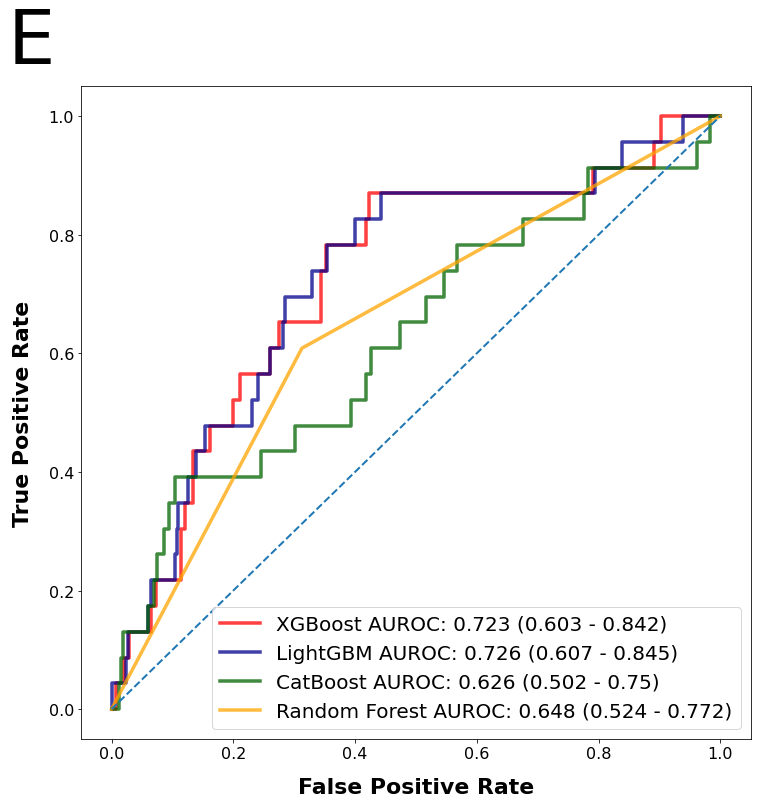

In [48]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'red', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='darkblue', linewidth = 3.5, alpha = 0.75)

cb_fpr, cb_tpr, _ = roc_curve(y_test, probs_cb)
cb_label = 'CatBoost AUROC: ' + cb_auroc
pyplot.plot(cb_fpr, cb_tpr, label = cb_label, color = 'darkgreen', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'orange', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('E', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/complications_roc.png', dpi=300)
pyplot.show()

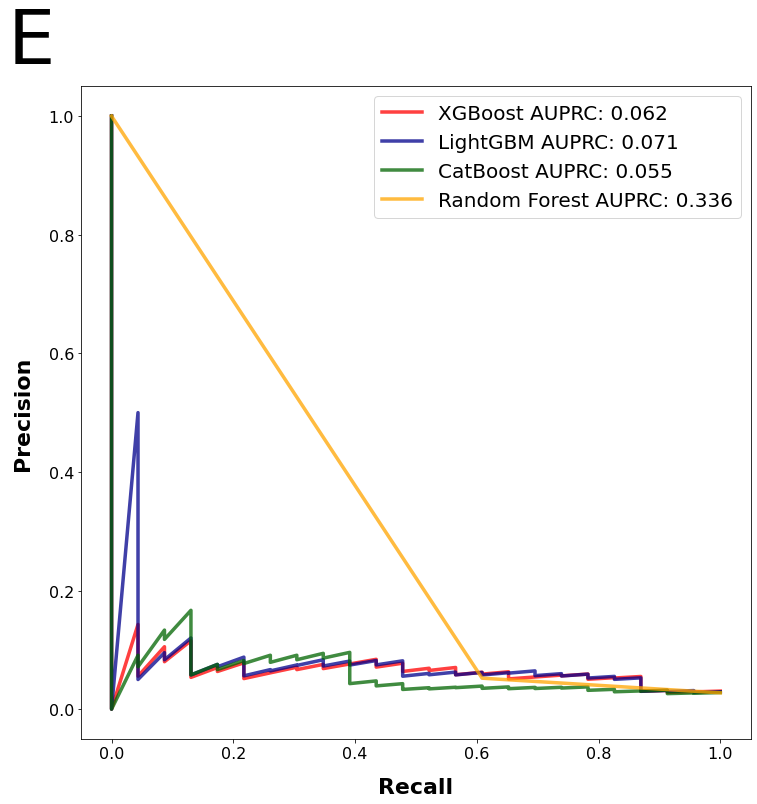

In [49]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

pyplot.plot(xgb_recall, xgb_precision, label='XGBoost AUPRC: {:.3f}'.format(xgb_auprc), color = 'red', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall, lgb_precision, label='LightGBM AUPRC: {:.3f}'.format(lgb_auprc), color = 'darkblue', linewidth = 3.5, alpha = 0.75)
pyplot.plot(cb_recall, cb_precision, label='CatBoost AUPRC: {:.3f}'.format(cb_auprc), color = 'darkgreen', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall, rf_precision, label='Random Forest AUPRC: {:.3f}'.format(rf_auprc), color = 'orange', linewidth = 3.5, alpha = 0.75)


pyplot.title('E', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/complications_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [50]:
results = {'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results}

results = pd.DataFrame(results, columns = ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest'])

results

,XGBoost,LightGBM,CatBoost,Random Forest
0,0.348,0.348,0.0,0.609
1,0.071,0.073,0.0,0.052
2,0.118,0.121,0.0,0.096
3,0.856,0.861,0.972,0.685
4,0.105,0.109,0.0,0.104
5,0.723 (0.603 - 0.842),0.726 (0.607 - 0.845),0.626 (0.502 - 0.75),0.648 (0.524 - 0.772)
6,0.062,0.071,0.055,0.336


In [51]:
results = pd.DataFrame({'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results})

results = results.T

results.columns = ['Precision', 'Recall', 'F1', 'Accuracy', 'MCC', 'AUROC (95% CI)', 'AUPRC']

results.to_csv('/content/drive/MyDrive/NTDB-Epidural/complications_results.csv')

results

,Precision,Recall,F1,Accuracy,MCC,AUROC (95% CI),AUPRC
XGBoost,0.348,0.071,0.118,0.856,0.105,0.723 (0.603 - 0.842),0.062
LightGBM,0.348,0.073,0.121,0.861,0.109,0.726 (0.607 - 0.845),0.071
CatBoost,0.0,0.0,0.0,0.972,0.0,0.626 (0.502 - 0.75),0.055
Random Forest,0.609,0.052,0.096,0.685,0.104,0.648 (0.524 - 0.772),0.336


# SHAP Plots

In [52]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [53]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test)
xgb_shap_values = xgb_explainer(x_test)

Permutation explainer: 836it [01:47,  7.28it/s]


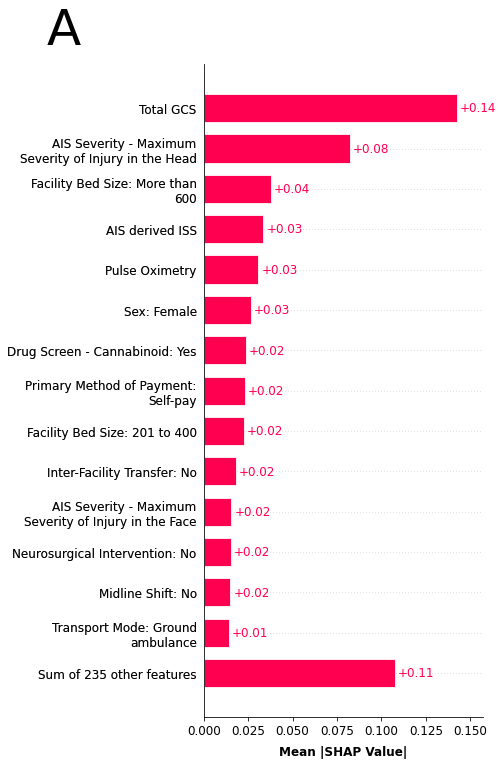

In [54]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/complications_shap_xgb.png', dpi=300, bbox_inches='tight')

In [55]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test)
lgb_shap_values = lgb_explainer(x_test)

Permutation explainer: 836it [02:00,  6.32it/s]


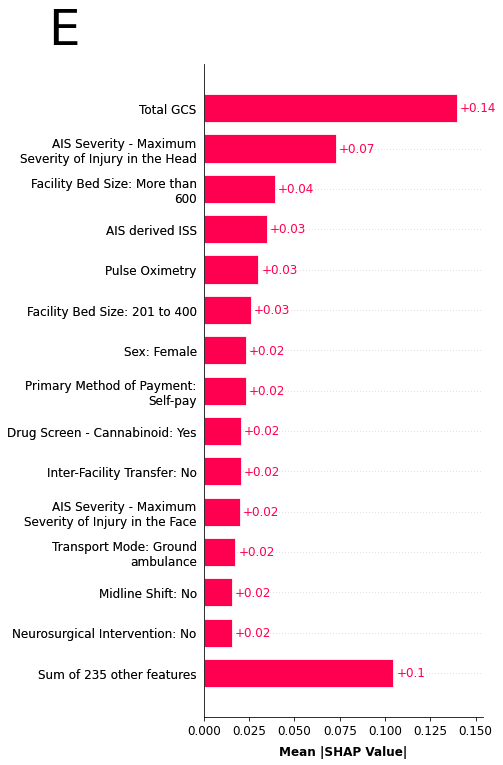

In [56]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('E', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/complications_shap_lgb.png', dpi=300, bbox_inches='tight')

In [57]:
#Calculate SHAP values for CatBoost.

cb_explainer = shap.Explainer(cb.predict, x_test)
cb_shap_values = cb_explainer(x_test)

Permutation explainer: 836it [02:35,  5.04it/s]


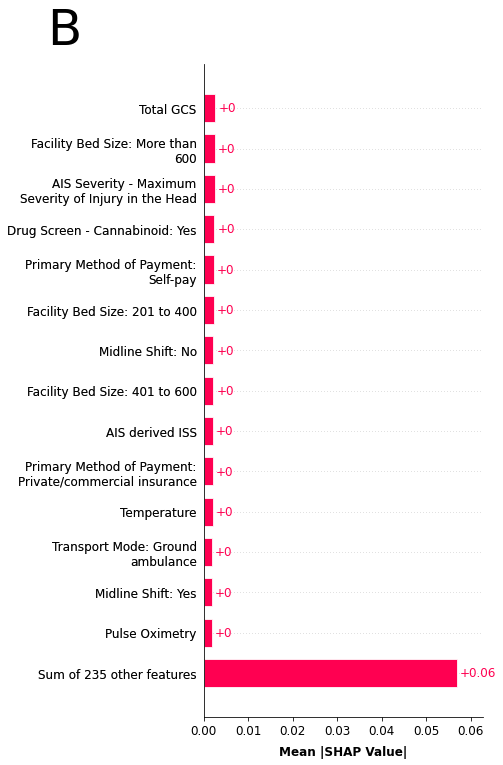

In [58]:
#Plot SHAP bar plot for CatBoost.

shap.plots.bar(cb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/complications_shap_cb.png', dpi=300, bbox_inches='tight')

In [59]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test)
rf_shap_values = rf_explainer(x_test)

Permutation explainer: 836it [28:04,  2.03s/it]


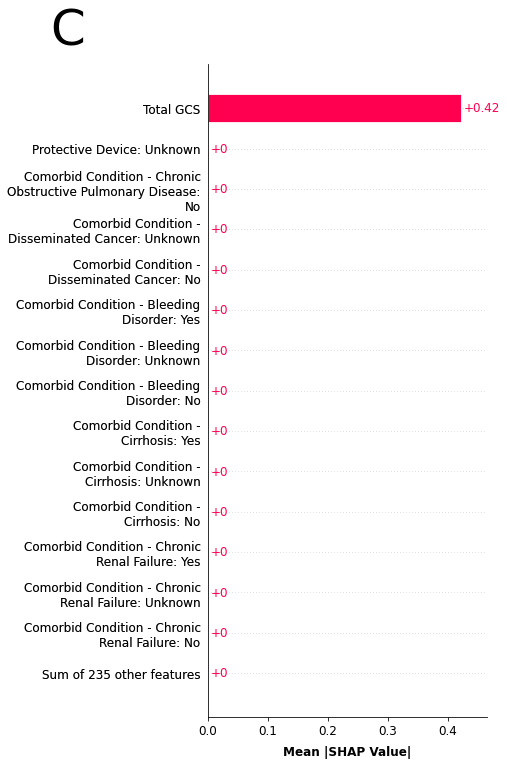

In [60]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/complications_shap_rf.png', dpi=300, bbox_inches='tight')